# Pytorch Implementation of different variational lower bounds on Mutual Information

All those bounds were derived from the work of Ben Poole and al., "On Variational Bounds of Mutual Information"

Their TensorFlow implementation, as well as useful insights, are available on GitHub : https://github.com/google-research/google-research/blob/master/vbmi/vbmi_demo.ipynb

In [1]:
import torch
import math
from torch import nn
from torch import cuda
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Snippet of code written to take benefits of GPU computation
train_on_GPU = cuda.is_available()
assert train_on_GPU, "please run this code on GPU (Google Collab is free and sufficient for instance)"

### Critic ( f(x,y) ) and Baseline ( a(y) ) neural networks 

In [3]:
#Separate Critic Implementation
class MINE(nn.Module):
    def __init__(self,input_dim,zdim):
        super(MINE, self).__init__()

        self.input_dim = input_dim
        self.zdim = zdim
        self.moving_average = None

        self.MLP_g = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )
        self.MLP_h = nn.Sequential(
            nn.Linear(zdim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )


    def forward(self, x, z):
        x = x.view(-1,self.input_dim)
        z = z.view(-1,self.zdim)
        x_g = self.MLP_g(x) #Batchsize x 32
        y_h = self.MLP_h(z) #Batchsize x 32
        scores = torch.matmul(y_h,torch.transpose(x_g,0,1))

        return scores #Each element i,j is a scalar in R. f(xi,proj_j)
    
class baseline_MLP(nn.Module):
    def __init__(self,input_dim):
        super(baseline_MLP, self).__init__()

        self.input_dim = input_dim

        self.MLP = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = x.view(-1,self.input_dim)
        res = self.MLP(x) 

        #Output a scalar which is the log-baseline : log a(y)  for interpolated bound
        return res

### Bounds and useful functions

1) NWJ (Mine-f) - Used in InfoMAX VAE framework. High Variance, Low bias, low stability

In [4]:
def reduce_logmeanexp_nodiag(x, axis=None):
    batch_size = x.size()[0]
    logsumexp = torch.logsumexp(x - torch.diag(np.inf * torch.ones(batch_size).cuda()),dim=[0,1])
    num_elem = batch_size * (batch_size - 1.)
    return logsumexp - torch.log(torch.tensor(num_elem).cuda())

def tuba_lower_bound(scores, log_baseline=None):
    if log_baseline is not None:
        scores -= log_baseline[:,None]
    batch_size = torch.tensor(scores.size()[0],dtype=torch.float32)
    joint_term= torch.mean(torch.diag(scores))
    marg_term=torch.exp(reduce_logmeanexp_nodiag(scores))
    return 1. + joint_term - marg_term

def nwj_bound(scores):
    return tuba_lower_bound(scores - 1.)

2) infoNCE (Noise Contrastive Estimation Loss) bound

In [5]:
#Compute the Noise Constrastive Estimation (NCE) loss
def infoNCE_bound(scores):
    '''Bound from Van Den Oord and al. (2018)'''
    nll = torch.mean( torch.diag(scores) - torch.logsumexp(scores,dim=1))
    k =scores.size()[0]
    mi = np.log(k) + nll

    return mi

3) Interpolated Bound (between NWJ and infoNCE), as proposed by Ben Poole and al. to control the bias-variance trade-off

In [6]:
def log_interpolate(log_a, log_b, alpha_logit):
    '''Numerically stable implmentation of log(alpha * a + (1-alpha) *b)
    Compute the log baseline for the interpolated bound
    baseline is a(y)'''
    log_alpha = -F.softplus(torch.tensor(-alpha_logit).cuda())
    log_1_minus_alpha = -F.softplus(torch.tensor(alpha_logit).cuda())
    y = torch.logsumexp( torch.stack((log_alpha + log_a, log_1_minus_alpha + log_b)), dim=0)
    return y

def compute_log_loomean(scores):
    '''Compute the log leave one out mean of the exponentiated scores'''
    max_scores, _ = torch.max(scores, dim=1,keepdim=True)

    lse_minus_max = torch.logsumexp(scores-max_scores,dim=1,keepdim=True)
    d = lse_minus_max + (max_scores - scores)
    
    d_not_ok = torch.eq(d, 0.)
    d_ok = ~d_not_ok
    safe_d = torch.where(d_ok, d, torch.ones_like(d).cuda()) #Replace zeros by 1 in d

    loo_lse = scores + (safe_d + torch.log(-torch.expm1(-safe_d))) #Stable implementation of softplus_inverse
    loo_lme = loo_lse - np.log(scores.size()[1] - 1.)
    return loo_lme

#Compute interporlate lower bound of MI
def interp_bound(scores, baseline, alpha_logit):
    '''
    New lower bound on mutual information proposed by Ben Poole and al.
    in "On Variational Bounds of Mutual Information"
    It allows to explictily control the biais-variance trade-off.
    For MI estimation -> This bound with a small alpha is much more stable but
    still small biais than NWJ / Mine-f bound !
    Return a scalar, the lower bound on MI
    '''
    batch_size = scores.size()[0]
    nce_baseline = compute_log_loomean(scores)

    interpolated_baseline = log_interpolate(nce_baseline,
        baseline[:,None].repeat(1,batch_size), alpha_logit) #Interpolate NCE baseline with a learnt baseline

    #Marginal distribution term
    critic_marg = scores - torch.diag(interpolated_baseline)[:,None]  #None is equivalent to newaxis
    marg_term = torch.exp(reduce_logmeanexp_nodiag(critic_marg))

    #Joint distribution term
    critic_joint = torch.diag(scores)[:,None] - interpolated_baseline
    joint_term = (torch.sum(critic_joint) - torch.sum(torch.diag(critic_joint))) / (batch_size * (batch_size - 1.))
    return 1 + joint_term - marg_term

### Today dataset. True MI is known.

For a rho fixed at 0.7 and variables of dimensionality 20, the true MI is 6.733445532637656


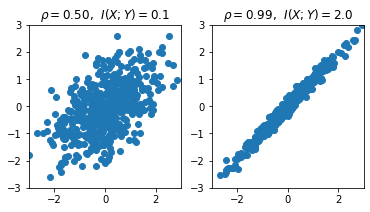

In [7]:
def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=64):
  """Generate samples from a correlated Gaussian distribution."""
  x, eps = torch.split(torch.normal(0,1,size=(batch_size,2*dim)),dim,dim=1)
  y = rho * x + torch.sqrt(torch.tensor(1. - rho**2, dtype=torch.float32)) * eps
  return x, y

def rho_to_mi(dim, rho):
  return -0.5  * np.log(1-rho**2) * dim

plt.figure(figsize=(6,3))
for i, rho in enumerate([0.5,0.99]):
    plt.subplot(1,2, i+1)
    x,y = sample_correlated_gaussian(batch_size=500, dim=1, rho=rho)
    plt.scatter(x[:,0], y[:,0])
    plt.title(r'$\rho=%.2f$,  $I(X; Y)=%.1f$' % (rho, rho_to_mi(1, rho)))
    plt.xlim(-3, 3); plt.ylim(-3, 3);
    
print(f'For a rho fixed at 0.7 and variables of dimensionality 20, the true MI is {rho_to_mi(20,0.7)}')
    

For the following results example, we will use a fixed rho of 0.7, variables of 20 dim, and thus we expect a true MI of 6.73

### Training of Networks Framework

In [13]:
def train_MINE(MINE,epochs,batch_size=256,bound_type='infoNCE',baseline=None,lr_interpolate=5e-4,alpha_logit=0.):
    '''
    bound_type argmunent defines the type of lower bound on MI that is used ('infoNCE', 'NWJ' or 'interpolated')
    '''
    
    ######################################
    ###### Parameter to control stability #
    #######################################
    lr_interpolate = lr_interpolate #lr for the interpolated bound
    batch_size = batch_size
    alpha_logit = alpha_logit

    optimizer = optim.Adam(MINE.parameters(),lr=0.0005)
    if bound_type=='interpolated':
        assert baseline!=None, "please provide a valid NN to represent the baseline a(y)"
        optimizer = optim.Adam(list(MINE.parameters())+list(baseline.parameters()),lr=lr_interpolate)
        #optimizer = optim.Adam(MINE.parameters(),lr=0.00001)
        #optimizer2 = optim.Adam(baseline.parameters(),lr=0.0000001)

    #decayRate = 0.6
    #lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=300, gamma=decayRate)

    history_MI = []


    for epoch in range(epochs):

        MI_epoch = 0

        for i in range(50): #Mimic a dataset of size 50*Batch_Size


            x, y = sample_correlated_gaussian(dim=20, rho=0.70, batch_size=batch_size)
            x = x.cuda()
            y = y.cuda()
            MI_loss = None
            if bound_type=='infoNCE': #CONSTANT BASELINE
                scores = MINE(x,y)
                MI_xz = infoNCE_bound(scores)
                MI_loss = -MI_xz
            elif bound_type=='NWJ': #CONSTANT BASELINE
                scores=MINE(x,y)
                MI_xz = nwj_bound(scores)
                MI_loss= -MI_xz
            elif bound_type=='interpolated': # USE OF A LEARNT BASELINE
                scores = MINE(x,y)
                log_baseline = torch.squeeze(baseline(y))
                alpha_logit = alpha_logit # sigmoid(0.) = 0.5, that correspond to an alpha of 0.5
                MI_xz = interp_bound(scores, log_baseline, alpha_logit)
                MI_loss = -MI_xz
            else:
                assert False, "Please give a valid bound_type, 'infoNCE', 'NWJ' or 'interpolated'"



            optimizer.zero_grad()
            MI_loss.backward()
            optimizer.step()

            MI_epoch += MI_xz

        MI_epoch /= 50
        history_MI.append(MI_epoch.detach().cpu().numpy())
        #lr_scheduler.step()

        if epoch % 5 == 0:
            print('==========> Epoch: {} ==========> MI: {:.4f}'.format(epoch, MI_epoch))

    print('Finished Training')
    return np.asarray(history_MI)
                  
def MINE_metric(batch_size,lr_interpolate,alpha_logit,bound_type='infoNCE',epoch=100):

    MINEnet = MINE(20,zdim=20)
    MINEnet.cuda()

    baseline=None
    if bound_type=='interpolated':
        baseline=baseline_MLP(20) #a(y), take y as input
        baseline.cuda()
    history_MI = train_MINE(MINEnet,epoch,batch_size,bound_type,baseline,lr_interpolate,alpha_logit)

    return history_MI


def compute_MI(batch_size,lr_interpolate=5e-4,alpha_logit=0.,save_path=None,bound_type='infoNCE',epoch=100):
    '''
    bound_type = 'infoNCE' or 'interpolated'
        define the bound on MI that is used to estimate and optimize MI
        -'infoNCE' van den Oord implementation (Noise Contrastive Coding loss)
        -'NWJ' = Mine-f bound
        -'interpolated' Ben Poole implementation, with alpha = 0.5
        Guideline : Use NCE for representation learning, interpolated for MI estimation
    '''
    MI_history = MINE_metric(batch_size,lr_interpolate,alpha_logit,bound_type,epoch)

    if save_path != None:
        MI_pkl_path = save_path+f'/MI_training_history.pkl'
        with open(MI_pkl_path, 'wb') as f:
            pkl.dump(MI_history, f, protocol=pkl.HIGHEST_PROTOCOL)

    MI_Score = np.mean(MI_history[-50:])

    plt.plot(MI_history)
    plt.hlines(MI_Score,0,len(MI_history))
    plt.text(10,MI_Score+np.max(MI_history)/50,str(np.round(MI_Score,2)))
    if save_path != None:
        plt.savefig(save_path+f'MI_score_plot.png')
    plt.title(f"Mutual information estimation with bound '{bound_type}', true MI is 6.73")
    plt.show()

    return MI_Score


### Results with infoNCE bound : Low variance, very stable but high bias (ln(batch_size))

Plots are over epcohs, for which MI is average over 50 batches

==========> Epoch: 0 ==========> MI: 1.7247
==========> Epoch: 5 ==========> MI: 5.1457
==========> Epoch: 10 ==========> MI: 5.1364
==========> Epoch: 15 ==========> MI: 5.1700
==========> Epoch: 20 ==========> MI: 5.1713
==========> Epoch: 25 ==========> MI: 5.1891
==========> Epoch: 30 ==========> MI: 5.1809
==========> Epoch: 35 ==========> MI: 5.1934
==========> Epoch: 40 ==========> MI: 5.1700
==========> Epoch: 45 ==========> MI: 5.1780
==========> Epoch: 50 ==========> MI: 5.1746
==========> Epoch: 55 ==========> MI: 5.1712
==========> Epoch: 60 ==========> MI: 5.1743
==========> Epoch: 65 ==========> MI: 5.2012
==========> Epoch: 70 ==========> MI: 5.2001
==========> Epoch: 75 ==========> MI: 5.2081
==========> Epoch: 80 ==========> MI: 5.1883
==========> Epoch: 85 ==========> MI: 5.2049
==========> Epoch: 90 ==========> MI: 5.2025
==========> Epoch: 95 ==========> MI: 5.1990
Finished Training


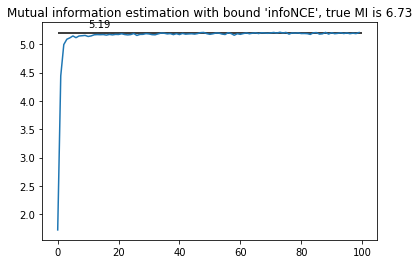

5.1917253

In [ ]:
compute_MI(batch_size=512,save_path=None,bound_type='infoNCE')

### Results with NWJ bounds, high variance, quite unstable, but low bias

==========> Epoch: 0 ==========> MI: 0.6357
==========> Epoch: 5 ==========> MI: 4.4729
==========> Epoch: 10 ==========> MI: 4.7187
==========> Epoch: 15 ==========> MI: 5.0222
==========> Epoch: 20 ==========> MI: 5.1848
==========> Epoch: 25 ==========> MI: 2.8760
==========> Epoch: 30 ==========> MI: 3.4346
==========> Epoch: 35 ==========> MI: 4.3211
==========> Epoch: 40 ==========> MI: 4.7388
==========> Epoch: 45 ==========> MI: 4.3320
==========> Epoch: 50 ==========> MI: 5.1366
==========> Epoch: 55 ==========> MI: 4.6311
==========> Epoch: 60 ==========> MI: 5.2237
==========> Epoch: 65 ==========> MI: 5.4413
==========> Epoch: 70 ==========> MI: 5.4093
==========> Epoch: 75 ==========> MI: 5.4698
==========> Epoch: 80 ==========> MI: 5.1460
==========> Epoch: 85 ==========> MI: 5.2752
==========> Epoch: 90 ==========> MI: 5.4570
==========> Epoch: 95 ==========> MI: 5.3756
Finished Training


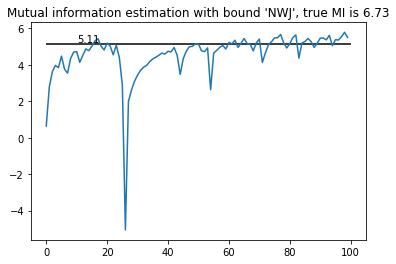

5.1147194

In [ ]:
compute_MI(batch_size=512,save_path=None,bound_type='NWJ')

### Results with interpolated bound, alpha = 0.5 and alpha = 0.01

By varying alpha we interpolate between NWJ (alpha=0) and infoNCE (alpha=1) lower bound on MI. This allows to control the bias-variance trade-off.

To estimate MI between to variable, a low alpha (alpha = 0.01, alpha_logit ~= -5.) allows a small biais (similar to NWJ) but a much lower variance than NWJ.

==========> Epoch: 0 ==========> MI: 1.7794
==========> Epoch: 5 ==========> MI: 5.5705
==========> Epoch: 10 ==========> MI: 5.6203
==========> Epoch: 15 ==========> MI: 5.6793
==========> Epoch: 20 ==========> MI: 5.6604
==========> Epoch: 25 ==========> MI: 5.6766
==========> Epoch: 30 ==========> MI: 5.6800
==========> Epoch: 35 ==========> MI: 5.6913
==========> Epoch: 40 ==========> MI: 5.6889
==========> Epoch: 45 ==========> MI: 5.6803
==========> Epoch: 50 ==========> MI: 5.6960
==========> Epoch: 55 ==========> MI: 5.7073
==========> Epoch: 60 ==========> MI: 5.7240
==========> Epoch: 65 ==========> MI: 5.7071
==========> Epoch: 70 ==========> MI: 5.7089
==========> Epoch: 75 ==========> MI: 5.6972
==========> Epoch: 80 ==========> MI: 5.7073
==========> Epoch: 85 ==========> MI: 5.7087
==========> Epoch: 90 ==========> MI: 5.7040
==========> Epoch: 95 ==========> MI: 5.6852
Finished Training


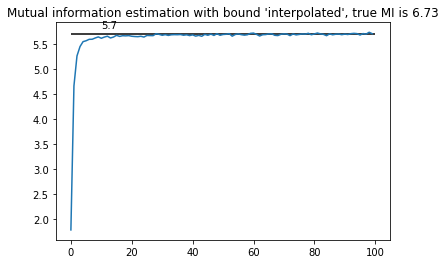

5.7002544

In [11]:
compute_MI(batch_size=512,lr_interpolate=5e-4,alpha_logit=0.,save_path=None,bound_type='interpolated',epoch=100)

==========> Epoch: 0 ==========> MI: 1.4026
==========> Epoch: 5 ==========> MI: 5.6155
==========> Epoch: 10 ==========> MI: 5.8089
==========> Epoch: 15 ==========> MI: 6.0015
==========> Epoch: 20 ==========> MI: 6.0603
==========> Epoch: 25 ==========> MI: 6.0497
==========> Epoch: 30 ==========> MI: 6.1314
==========> Epoch: 35 ==========> MI: 6.0536
==========> Epoch: 40 ==========> MI: 6.0727
==========> Epoch: 45 ==========> MI: 6.0899
==========> Epoch: 50 ==========> MI: 6.1158
==========> Epoch: 55 ==========> MI: 6.1475
==========> Epoch: 60 ==========> MI: 6.1096
==========> Epoch: 65 ==========> MI: 6.1267
==========> Epoch: 70 ==========> MI: 6.1692
==========> Epoch: 75 ==========> MI: 6.1345
==========> Epoch: 80 ==========> MI: 6.1191
==========> Epoch: 85 ==========> MI: 6.1589
==========> Epoch: 90 ==========> MI: 6.1820
==========> Epoch: 95 ==========> MI: 6.1237
==========> Epoch: 100 ==========> MI: 6.1513
==========> Epoch: 105 ==========> MI: 6.1175
==========

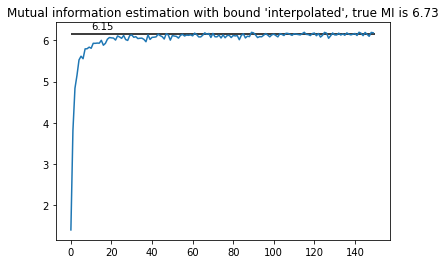

6.1460576

In [15]:
compute_MI(batch_size=512,lr_interpolate=5e-4,alpha_logit=-5.,save_path=None,bound_type='interpolated',epoch=150)